# Final Project: Meal Nutrition Analysis

## By:
## Chetan Sai Borra
## UIN: 436000947
## Sreedhar Reddy Pacharla
## UIN:334002545

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import ast
import torch
from torch.nn.utils.rnn import pad_sequence
import math
import torch.optim as optim
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torchinfo import summary

<b> We are using the GPU for the traning so we change device to CUDA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## (a) (20%) Data preprocessing: 
Preprocess each modality appropriately. For example: the length of some modalities is variable but most models required fixed-length input; some modalities are categorical whereas others are continuous numerical.

#### Importing training & testing data from csv files 

In [3]:
df = pd.read_csv('cgm_train.csv')
df.head()

,Subject ID,Day,Breakfast Time,Lunch Time,CGM Data
0,1,2,2021-09-19 08:41:00,2021-09-19 12:24:00,"[('2021-09-19 08:20:00', 98.26666666666667), (..."
1,1,3,2021-09-20 09:50:00,2021-09-20 15:20:00,"[('2021-09-20 09:10:00', 97.18333333333334), (..."
2,1,4,2021-09-21 09:34:00,2021-09-21 13:09:00,"[('2021-09-21 09:20:00', 107.36666666666666), ..."
3,1,5,2021-09-22 09:46:00,2021-09-22 13:50:00,"[('2021-09-22 09:25:00', 107.28333333333333), ..."
4,1,6,2021-09-23 09:07:00,2021-09-23 13:17:00,"[('2021-09-23 08:55:00', 103.0), ('2021-09-23 ..."


In [4]:
df.shape

(324, 5)

In [5]:
df_test = pd.read_csv('cgm_test.csv')
df.head()

,Subject ID,Day,Breakfast Time,Lunch Time,CGM Data
0,1,2,2021-09-19 08:41:00,2021-09-19 12:24:00,"[('2021-09-19 08:20:00', 98.26666666666667), (..."
1,1,3,2021-09-20 09:50:00,2021-09-20 15:20:00,"[('2021-09-20 09:10:00', 97.18333333333334), (..."
2,1,4,2021-09-21 09:34:00,2021-09-21 13:09:00,"[('2021-09-21 09:20:00', 107.36666666666666), ..."
3,1,5,2021-09-22 09:46:00,2021-09-22 13:50:00,"[('2021-09-22 09:25:00', 107.28333333333333), ..."
4,1,6,2021-09-23 09:07:00,2021-09-23 13:17:00,"[('2021-09-23 08:55:00', 103.0), ('2021-09-23 ..."


In [6]:
df_test.shape

(73, 5)

In [7]:
df2 = pd.read_csv('demo_viome_train.csv')
df2.head()

,Subject ID,Age,Gender,Weight,Height,Race,Diabetes Status,A1C,Baseline Fasting Glucose,Insulin,Triglycerides,Cholesterol,HDL,Non-HDL,LDL,VLDL,CHO/HDL Ratio,HOMA-IR,BMI,Viome
0,1,27,0,133.8,65.00,Hispanic/Latino,1,5.4,91.0,2.5,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
1,2,49,1,169.2,62.00,Hispanic/Latino,1,5.5,93.0,14.8,61.0,181.0,91.0,90.0,78.0,12.0,2.0,3.398519,30.943704,"-9.395216776716872,-7.315438412832852,1.103724..."
2,3,59,1,157.0,64.00,Hispanic/Latino,3,6.5,118.0,17.4,154.0,190.0,74.0,116.0,90.0,31.0,2.6,5.069630,26.946045,"-11.007947281293239,-8.444134921199856,0.28806..."
3,5,51,1,172.0,62.50,Hispanic/Latino,3,6.6,144.0,12.9,392.0,269.0,38.0,231.0,157.0,78.0,7.1,4.586667,30.954496,"-6.21833166351615,-5.868646092839025,-6.612900..."
4,6,51,1,197.0,68.75,White,1,5.2,96.0,6.4,75.0,203.0,72.0,131.0,118.0,15.0,2.8,1.517037,29.300575,"-6.7953636871125,-6.50799421035929,-1.85678011..."


In [8]:
df2.shape

(36, 20)

#### Viome data has 27 values in a list we split them into 27 different columns and add it to the table.

In [9]:
viome_split = df2["Viome"].str.split(",", expand=True)
viome_split.columns = [f"Viome_{i+1}" for i in range(27)]

df2 = pd.concat([df2.drop(columns=["Viome"]), viome_split], axis=1)
df2.head()

,Subject ID,Age,Gender,Weight,Height,Race,Diabetes Status,A1C,Baseline Fasting Glucose,Insulin,...,Viome_18,Viome_19,Viome_20,Viome_21,Viome_22,Viome_23,Viome_24,Viome_25,Viome_26,Viome_27
0,1,27,0,133.8,65.00,Hispanic/Latino,1,5.4,91.0,2.5,...,1.183266342434556,0.12395143567353584,1.4227163082959362,-0.20177697617718063,0.77384349157387,-0.12545725074079783,-0.35239560171981826,-0.2415776524398149,-0.13589393572400146,-0.16438935960398904
1,2,49,1,169.2,62.00,Hispanic/Latino,1,5.5,93.0,14.8,...,0.3484509423875741,1.5914514848037458,0.7489444683516676,-0.017462664219766708,0.5143437855285714,-0.39220949745686,-0.2111726005029046,-0.21012153894447513,-0.007722671801359701,-0.09021675435769132
2,3,59,1,157.0,64.00,Hispanic/Latino,3,6.5,118.0,17.4,...,-0.20206792944078342,-1.578614388998433,-1.3568882514162115,0.14322972381389498,-1.742320750623393,0.45129517791385904,0.30456197997695217,-0.049944872860956335,0.18803237078045107,-0.039500402757854144
3,5,51,1,172.0,62.50,Hispanic/Latino,3,6.6,144.0,12.9,...,-3.206188210794852,-1.994911470233713,1.8676848980570462,-1.0292189866159556,-0.4123514747509282,-0.6574471382574044,0.11585506516668514,0.09338434076519442,0.10464917189192927,0.009800474185485616
4,6,51,1,197.0,68.75,White,1,5.2,96.0,6.4,...,0.7386935516057005,2.9388310895381395,-2.335280545552887,0.16202422739944747,-0.4398284775824546,0.1766640437184336,0.47470246278815464,0.03401198568437244,0.2100989546512499,0.3386554630077799


In [10]:
df2_test = pd.read_csv('demo_viome_test.csv')
df2_test.head()

,Subject ID,Age,Gender,Weight,Height,Race,Diabetes Status,A1C,Baseline Fasting Glucose,Insulin,Triglycerides,Cholesterol,HDL,Non-HDL,LDL,VLDL,CHO/HDL Ratio,HOMA-IR,BMI,Viome
0,4,33,1,262.6,66.0,Hispanic/Latino,1,5.5,105.0,19.4,300.0,267.0,46.0,221.0,164.0,60.0,5.8,5.02963,42.380119,"-8.159737251015637,-6.592865703640219,2.144919..."
1,21,63,1,142.6,62.5,African American,1,5.3,98.0,9.3,63.0,178.0,51.0,127.0,115.0,13.0,3.5,2.25037,25.663437,"0.9132611196203955,5.118312363484425,0.7490546..."
2,27,24,1,173.2,67.0,Hispanic/Latino,1,4.7,90.0,6.3,40.0,134.0,57.0,77.0,67.0,8.0,2.4,1.40000,27.123992,"44.5262736442813,-9.295344245726843,0.14686137..."
3,34,24,0,185.0,71.0,White,1,4.6,80.0,4.2,104.0,161.0,61.0,100.0,81.0,21.0,2.6,0.82963,25.799445,"-0.16622831775986097,9.301906171641043,-0.3511..."
4,39,45,1,147.2,62.0,Hispanic/Latino,3,8.3,158.0,17.5,177.0,145.0,38.0,107.0,77.0,35.0,3.8,6.82716,26.920291,"0.6403789380570297,7.722202301019041,-0.651212..."


In [11]:
df2_test.shape

(9, 20)

In [12]:
viome_split = df2_test["Viome"].str.split(",", expand=True)
viome_split.columns = [f"Viome_{i+1}" for i in range(27)]

df2_test = pd.concat([df2_test.drop(columns=["Viome"]), viome_split], axis=1)
df2_test.head()

,Subject ID,Age,Gender,Weight,Height,Race,Diabetes Status,A1C,Baseline Fasting Glucose,Insulin,...,Viome_18,Viome_19,Viome_20,Viome_21,Viome_22,Viome_23,Viome_24,Viome_25,Viome_26,Viome_27
0,4,33,1,262.6,66.0,Hispanic/Latino,1,5.5,105.0,19.4,...,-2.2256674821423728,0.9694850819703377,0.6124668283036344,-0.26328050242355777,0.3894822461222587,-0.6226216287550204,-0.10161256222637777,-0.6392918283618187,-0.15390863826620915,-0.044839111398021526
1,21,63,1,142.6,62.5,African American,1,5.3,98.0,9.3,...,-0.6822460688680451,1.0850481036558401,0.4902991147737821,2.732961444299114,-2.2187157489773384,-1.1302991634409698,-2.940799640959322,3.960831855701474,-0.4830978379302278,2.9363744546719714
2,27,24,1,173.2,67.0,Hispanic/Latino,1,4.7,90.0,6.3,...,0.12371631362043423,0.08155345866645469,-0.1063866758846027,-0.344747537468271,0.020508207999820116,-0.17352390224847097,-0.02833939914541317,0.003207265108650839,0.08461351699483927,-0.01863067378158023
3,34,24,0,185.0,71.0,White,1,4.6,80.0,4.2,...,0.25836785596665496,0.7823487933896984,0.49213750570854964,0.8814406856376108,-1.5276686859459991,-1.5145434150223995,-0.8028196560137701,2.2057794297370803,0.40349250505745077,-0.2969366576124057
4,39,45,1,147.2,62.0,Hispanic/Latino,3,8.3,158.0,17.5,...,0.27673744268601674,-0.7881606535284524,-0.12939222146429563,-1.505147856383716,1.9707438534674289,1.687687585524265,0.29224429923766015,-0.22866699612713806,-2.3388141183289735,1.3834538494689392


In [13]:
df3 = pd.read_csv('img_train.csv')
df3.head()

,Subject ID,Day,Image Before Breakfast,Image Before Lunch
0,1,2,"[[[140, 122, 108], [135, 118, 104], [118, 104,...","[[[41, 152, 201], [77, 164, 205], [88, 157, 13..."
1,1,3,"[[[67, 58, 47], [59, 52, 41], [51, 45, 35], [4...","[[[40, 59, 77], [35, 56, 72], [20, 36, 47], [9..."
2,1,4,"[[[199, 195, 193], [198, 193, 192], [196, 192,...","[[[53, 44, 38], [51, 43, 36], [54, 47, 39], [4..."
3,1,5,"[[[149, 121, 80], [157, 128, 86], [159, 130, 8...","[[[30, 28, 28], [20, 18, 17], [31, 27, 23], [2..."
4,1,6,"[[[175, 184, 198], [192, 206, 219], [160, 165,...","[[[74, 85, 100], [59, 69, 81], [73, 84, 96], [..."


In [14]:
df3_test = pd.read_csv('img_test.csv')
df3_test.head()

,Subject ID,Day,Image Before Breakfast,Image Before Lunch
0,4,2,"[[[55, 75, 29], [55, 77, 27], [53, 76, 24], [5...","[[[37, 42, 28], [36, 40, 25], [24, 31, 17], [7..."
1,4,3,"[[[56, 170, 210], [100, 189, 216], [140, 217, ...","[[[29, 34, 32], [29, 33, 32], [28, 31, 30], [2..."
2,4,6,"[[[227, 153, 39], [219, 145, 33], [211, 136, 3...","[[[55, 35, 29], [64, 29, 26], [71, 41, 43], [6..."
3,4,7,"[[[146, 192, 146], [145, 192, 148], [142, 189,...","[[[110, 108, 108], [115, 113, 115], [126, 123,..."
4,4,8,"[[[201, 239, 155], [208, 242, 156], [211, 242,...","[[[88, 87, 100], [95, 95, 107], [89, 90, 100],..."


In [15]:
label = pd.read_csv('label_train.csv')
label.head()

,Subject ID,Day,Breakfast Calories,Lunch Calories,Breakfast Carbs,Lunch Carbs,Breakfast Fat,Lunch Fat,Breakfast Protein,Lunch Protein
0,1,2,448.0,830,66.0,92,10.5,42.0,22.0,17
1,1,3,608.0,435,66.0,16,10.5,14.0,66.0,66
2,1,4,712.0,555,66.0,94,42.0,13.0,22.0,12
3,1,5,902.0,355,73.0,19,42.0,15.0,66.0,32
4,1,6,268.0,1180,24.0,81,10.5,54.5,22.0,88


In [16]:
new_order = ["Subject ID", "Day", "Breakfast Calories", "Breakfast Carbs", "Breakfast Fat", "Breakfast Protein", "Lunch Calories", "Lunch Carbs", "Lunch Fat", "Lunch Protein"]
label = label[new_order]
label.head()

,Subject ID,Day,Breakfast Calories,Breakfast Carbs,Breakfast Fat,Breakfast Protein,Lunch Calories,Lunch Carbs,Lunch Fat,Lunch Protein
0,1,2,448.0,66.0,10.5,22.0,830,92,42.0,17
1,1,3,608.0,66.0,10.5,66.0,435,16,14.0,66
2,1,4,712.0,66.0,42.0,22.0,555,94,13.0,12
3,1,5,902.0,73.0,42.0,66.0,355,19,15.0,32
4,1,6,268.0,24.0,10.5,22.0,1180,81,54.5,88


In [17]:
label_test = pd.read_csv('label_test_breakfast_only.csv')
label_test.head()

,Subject ID,Day,Breakfast Calories,Breakfast Carbs,Breakfast Fat,Breakfast Protein
0,4,2,448.0,66.0,10.5,22.0
1,4,3,608.0,66.0,10.5,66.0
2,4,6,268.0,24.0,10.5,22.0
3,4,7,448.0,66.0,10.5,22.0
4,4,8,608.0,66.0,10.5,66.0


### The data have some missing values about 5 missing values in cgm data and 33 missing images breakfast and lunch combined.

#### So we remove those indices from the training data.

In [18]:
indices_to_remove = [9, 17, 22, 43, 44, 63, 97, 110, 121, 136, 139, 158, 163, 172, 175, 176, 189, 198, 201, 217, 223, 225, 234, 252, 268, 272, 274, 275, 276, 278, 295, 296, 298, 311]

In [19]:
len(indices_to_remove)

34

#### Now we seperate the cgm data to preprocess it in both train and test

In [20]:
cgm_data = df['CGM Data']


In [21]:
cgm_test = df_test['CGM Data']

### Now we write a function to preprocess the cgm data.

1. we check for the empty data and remove that sample from the data.
2. we extract mean and std from the cgm values to normalize it.
3. For each sample we cyclic encode the time in hours and min.
4. if there is a missing time step we append 0's

In [22]:
def get_mean_std(sample):
    target = np.array([x[1] for x in sample])
    
    return target.mean(), target.std()
    


def load_processed_CGM(cgm_dat, total_len=95, train=False):
    print(f"Total Number of Samples = {len(cgm_dat)}")
    cgm_dat = [ast.literal_eval(x) for x in cgm_dat]
    for i in range(len(cgm_dat)):
        if len(cgm_dat[i]) == 0:
            print("Emtpy data at:", i)
    cgm_dat = [cgm_dat[x] for x in range(len(cgm_dat)) if x not in indices_to_remove]
    print(f"Total Number of Samples in after removing empty data = {len(cgm_dat)}")
    mean_std = np.array([get_mean_std(x) for x in cgm_dat])
    mean, std = mean_std.mean(axis=0) 
    cgm_data_with_hr_min = []
    
    for each_sample in cgm_dat:
        temp = []
        for time_stamp, cgm_value in each_sample:
            datetime_object = datetime.strptime(time_stamp, "%Y-%m-%d %H:%M:%S")
            hour_sin = math.sin((datetime_object.hour)*((2*math.pi)/24))
            hour_cos = math.cos((datetime_object.hour)*((2*math.pi)/24))
            
            minute_sin = math.sin((datetime_object.minute)*((2*math.pi)/60))
            minute_cos = math.cos((datetime_object.minute)*((2*math.pi)/60))
            
            temp.append((hour_sin, hour_cos, minute_sin, minute_cos, (cgm_value-mean)/std))
        current_len = len(temp)
        if current_len < total_len:
            while current_len < total_len:
                temp.append((0, 0, 0, 0, 0.0))
                current_len += 1
        elif current_len > total_len:
            temp = temp[:total_len]
        cgm_data_with_hr_min.append(temp)

    cgm_data_with_hr_min = torch.tensor(cgm_data_with_hr_min, dtype=torch.float32)
    
    return cgm_data_with_hr_min, mean, std

In [23]:
cgm_train, cgm_mean_train, cgm_std_train = load_processed_CGM(cgm_data, train=True)


Total Number of Samples = 324
Emtpy data at: 175
Emtpy data at: 176
Emtpy data at: 217
Emtpy data at: 225
Emtpy data at: 276
Total Number of Samples in after removing empty data = 290


#### Same for the test data

In [24]:
def load_processed_CGM(cgm_dat, total_len=95, train=False):
    print(f"Total Number of Samples = {len(cgm_dat)}")
    cgm_dat = [ast.literal_eval(x) for x in cgm_dat]
    for i in range(len(cgm_dat)):
        if len(cgm_dat[i]) == 0:
            print("Emtpy data at:", i)
    #cgm_dat = [cgm_dat[x] for x in range(len(cgm_dat)) if x not in indices_to_remove]
    print(f"Total Number of Samples in after removing empty data = {len(cgm_dat)}")
    mean_std = np.array([get_mean_std(x) for x in cgm_dat])
    mean, std = mean_std.mean(axis=0) 
    cgm_data_with_hr_min = []
    
    for each_sample in cgm_dat:
        temp = []
        for time_stamp, cgm_value in each_sample:
            datetime_object = datetime.strptime(time_stamp, "%Y-%m-%d %H:%M:%S")
            hour_sin = math.sin((datetime_object.hour)*((2*math.pi)/24))
            hour_cos = math.cos((datetime_object.hour)*((2*math.pi)/24))
            
            minute_sin = math.sin((datetime_object.minute)*((2*math.pi)/60))
            minute_cos = math.cos((datetime_object.minute)*((2*math.pi)/60))
            
            temp.append((hour_sin, hour_cos, minute_sin, minute_cos, (cgm_value-mean)/std))
        current_len = len(temp)
        if current_len < total_len:
            while current_len < total_len:
                temp.append((0, 0, 0, 0, 0.0))
                current_len += 1
        elif current_len > total_len:
            temp = temp[:total_len]
        cgm_data_with_hr_min.append(temp)

    cgm_data_with_hr_min = torch.tensor(cgm_data_with_hr_min, dtype=torch.float32)
    
    return cgm_data_with_hr_min, mean, std

In [25]:
cgm_test, cgm_mean_test, cgm_std_test = load_processed_CGM(cgm_test)

Total Number of Samples = 73
Total Number of Samples in after removing empty data = 73


# Now we check the shape of the data to validate it.

In [26]:
cgm_train.shape

torch.Size([290, 95, 5])

In [27]:
cgm_test.shape

torch.Size([73, 95, 5])

### Now we preprocess the image data

1. Remove the missing samples
2. convert image into numpy for faster training 

In [28]:
def load_image_data(df):
    image_data = df
    image_data.drop(indices_to_remove, axis=0, inplace=True)
    
    
    img_bf = image_data["Image Before Breakfast"]
    img_lh = image_data["Image Before Lunch"] 

    
    img_bf_processed = [ast.literal_eval(x) for x in img_bf]
    img_bf_processed = np.array(img_bf_processed, dtype="uint8")
    
    
    img_lh_processed = [ast.literal_eval(x) for x in img_lh]
    img_lh_processed = np.array(img_lh_processed, dtype="uint8")
    
    np.save("image_train_bf.npy", img_bf_processed)
    np.save("image_train_lh.npy", img_lh_processed)

In [29]:
load_image_data(df3)

### Now we do the same for the test images

In [30]:
def load_image_data(df):
    image_data = df
    #image_data.drop(indices_to_remove, axis=0, inplace=True)
    
    
    img_bf = image_data["Image Before Breakfast"]
    img_lh = image_data["Image Before Lunch"] 

    
    img_bf_processed = [ast.literal_eval(x) for x in img_bf]
    img_bf_processed = np.array(img_bf_processed, dtype="uint8")
    
    
    img_lh_processed = [ast.literal_eval(x) for x in img_lh]
    img_lh_processed = np.array(img_lh_processed, dtype="uint8")
    
    np.save("image_test_bf.npy", img_bf_processed)
    np.save("image_test_lh.npy", img_lh_processed)

In [31]:
load_image_data(df3_test)

### Now we load the train and test images that are in the numpy and convert it into tensor

In [32]:
image_train_bf = torch.tensor(np.load("image_train_bf.npy"), dtype=torch.float32)
image_train_bf = image_train_bf/255.0
image_train_lh = torch.tensor(np.load("image_train_lh.npy"), dtype=torch.float32)
image_train_lh = image_train_lh/255.0

In [33]:
image_test_bf = torch.tensor(np.load("image_test_bf.npy"), dtype=torch.float32).view(73, 3, 64, 64)
image_test_bf = image_test_bf/255.0
image_test_lh = torch.tensor(np.load("image_test_lh.npy"), dtype=torch.float32).view(73, 3, 64, 64)
image_test_lh = image_test_lh/255.0

#### We check the shape of the images to validata the data

In [34]:
image_train_bf.shape

torch.Size([290, 64, 64, 3])

In [35]:
image_train_lh.shape

torch.Size([290, 64, 64, 3])

In [36]:
image_test_bf.shape

torch.Size([73, 3, 64, 64])

In [37]:
image_test_lh.shape

torch.Size([73, 3, 64, 64])

### Now we preprocess the label data and remove the missing values and subject ID and Day form all the data

In [38]:
def load_train_labels(label1):
    labels = label1
    labels.drop(indices_to_remove, axis=0, inplace=True)
    labels.drop(["Subject ID", "Day"], axis=1, inplace=True)
    #selected_columns = ["Lunch Calories", "Lunch Carbs", "Lunch Fat", "Lunch Protein"]
    #labels = labels[selected_columns]
    labels_np = np.array(labels)
    mean = labels_np.mean(axis=0)
    std = labels_np.std(axis=0)
    labels_np = (labels_np - mean)/std
    labels_np = torch.tensor(labels_np, dtype=torch.float32)
    
    return labels_np, mean, std

In [39]:
output_train, output_mean, output_std = load_train_labels(label)

In [40]:
output_train.shape

torch.Size([290, 8])

###  Now we start preprocessing the Denogeaphic and viome data.

#### We join the demo_viome data with cgm data to match the persons based on the subject ID

In [41]:
final_combined = pd.merge(df, df2, on="Subject ID", how="inner")

In [42]:
final_combined_test = pd.merge(df_test, df2_test, on="Subject ID", how="inner")

In [43]:
final_combined.shape

(324, 50)

In [44]:
final_combined_test.shape

(73, 50)

In [45]:
from sklearn.preprocessing import LabelEncoder

### Now we process the data by removing the subject ID, Day and normalizing the numarical values and label encode the catogorical values.

In [46]:
structured_data = final_combined
structured_data = structured_data.drop('Day', axis=1)
structured_data = structured_data.drop('Subject ID', axis=1)
structured_data = structured_data.drop('CGM Data', axis=1)
label_encoder = LabelEncoder()
structured_data['Race'] = label_encoder.fit_transform(structured_data['Race'])
structured_data = structured_data.drop('Breakfast Time', axis=1)
structured_data = structured_data.drop('Lunch Time', axis=1)
categorical_features = ["Gender", "Race", "Diabetes Status"]
numerical_features = [col for col in structured_data.columns if col not in categorical_features]
for col in numerical_features:
    structured_data[col] = pd.to_numeric(structured_data[col], errors='coerce')
# Z-Normalization for numerical features
for col in numerical_features:
    mean = structured_data[col].mean()
    std = structured_data[col].std()
    structured_data[col] = (structured_data[col] - mean) / std
structured_data.head()

,Age,Gender,Weight,Height,Race,Diabetes Status,A1C,Baseline Fasting Glucose,Insulin,Triglycerides,...,Viome_18,Viome_19,Viome_20,Viome_21,Viome_22,Viome_23,Viome_24,Viome_25,Viome_26,Viome_27
0,-2.118044,0,-1.391791,0.259761,1,1,-0.930216,-1.034823,-1.403469,-0.543978,...,0.602649,0.095003,0.784446,-0.129831,0.471209,-0.074965,-0.442479,-0.118934,-0.199236,-0.036699
1,-2.118044,0,-1.391791,0.259761,1,1,-0.930216,-1.034823,-1.403469,-0.543978,...,0.602649,0.095003,0.784446,-0.129831,0.471209,-0.074965,-0.442479,-0.118934,-0.199236,-0.036699
2,-2.118044,0,-1.391791,0.259761,1,1,-0.930216,-1.034823,-1.403469,-0.543978,...,0.602649,0.095003,0.784446,-0.129831,0.471209,-0.074965,-0.442479,-0.118934,-0.199236,-0.036699
3,-2.118044,0,-1.391791,0.259761,1,1,-0.930216,-1.034823,-1.403469,-0.543978,...,0.602649,0.095003,0.784446,-0.129831,0.471209,-0.074965,-0.442479,-0.118934,-0.199236,-0.036699
4,-2.118044,0,-1.391791,0.259761,1,1,-0.930216,-1.034823,-1.403469,-0.543978,...,0.602649,0.095003,0.784446,-0.129831,0.471209,-0.074965,-0.442479,-0.118934,-0.199236,-0.036699


#### We do the same for the Test Data

In [47]:
structured_data_test = final_combined_test
structured_data_test = structured_data_test.drop('Day', axis=1)
structured_data_test = structured_data_test.drop('Subject ID', axis=1)
structured_data_test = structured_data_test.drop('CGM Data', axis=1)
label_encoder = LabelEncoder()
structured_data_test['Race'] = label_encoder.fit_transform(structured_data_test['Race'])
structured_data_test = structured_data_test.drop('Breakfast Time', axis=1)
structured_data_test = structured_data_test.drop('Lunch Time', axis=1)
categorical_features = ["Gender", "Race", "Diabetes Status"]
numerical_features = [col for col in structured_data_test.columns if col not in categorical_features]
for col in structured_data_test:
    structured_data_test[col] = pd.to_numeric(structured_data_test[col], errors='coerce')
# Z-Normalization for numerical features
for col in numerical_features:
    mean = structured_data_test[col].mean()
    std = structured_data_test[col].std()
    structured_data_test[col] = (structured_data_test[col] - mean) / std
structured_data_test.head()

,Age,Gender,Weight,Height,Race,Diabetes Status,A1C,Baseline Fasting Glucose,Insulin,Triglycerides,...,Viome_18,Viome_19,Viome_20,Viome_21,Viome_22,Viome_23,Viome_24,Viome_25,Viome_26,Viome_27
0,-0.474492,1,1.504438,0.29294,1,1,-0.398985,-0.305458,1.097171,2.418189,...,-2.702688,1.255517,1.174537,-0.189549,0.366736,-0.639927,0.628176,-0.670149,0.474518,-0.523628
1,-0.474492,1,1.504438,0.29294,1,1,-0.398985,-0.305458,1.097171,2.418189,...,-2.702688,1.255517,1.174537,-0.189549,0.366736,-0.639927,0.628176,-0.670149,0.474518,-0.523628
2,-0.474492,1,1.504438,0.29294,1,1,-0.398985,-0.305458,1.097171,2.418189,...,-2.702688,1.255517,1.174537,-0.189549,0.366736,-0.639927,0.628176,-0.670149,0.474518,-0.523628
3,-0.474492,1,1.504438,0.29294,1,1,-0.398985,-0.305458,1.097171,2.418189,...,-2.702688,1.255517,1.174537,-0.189549,0.366736,-0.639927,0.628176,-0.670149,0.474518,-0.523628
4,-0.474492,1,1.504438,0.29294,1,1,-0.398985,-0.305458,1.097171,2.418189,...,-2.702688,1.255517,1.174537,-0.189549,0.366736,-0.639927,0.628176,-0.670149,0.474518,-0.523628


#### Now we remove the missing values and make sure that all the cgm , images and demo_viome have same data

In [48]:
structured_data.drop(indices_to_remove, axis=0, inplace=True)

In [49]:
structured_data = np.array(structured_data, dtype=np.float32)

structured_data = torch.tensor(structured_data, dtype=torch.float32)


In [50]:
structured_data.shape

torch.Size([290, 45])

In [51]:
structured_data_test = np.array(structured_data_test, dtype=np.float32)

structured_data_test = torch.tensor(structured_data_test, dtype=torch.float32)


In [52]:
structured_data_test.shape

torch.Size([73, 45])

## (b) (10%) Data preparation: 
<b> Creating a multimodal dataset by merging all data modalities and labels and saving to a DataLoader 

#### Next we create a custome dataste to get the data samples

In [53]:
class CustomDataset(Dataset):
    def __init__(self, structured_data, output_train, image_train_lh, image_train_bf, cgm_train):
        self.structured_data = structured_data
        self.output_train = output_train
        self.image_train_lh = image_train_lh
        self.image_train_bf = image_train_bf
        self.cgm_train = cgm_train
    
    def __len__(self):
        return len(self.structured_data)
    
    def __getitem__(self, idx):
        structured = self.structured_data[idx]
        output = self.output_train[idx]
        image_lh = self.image_train_lh[idx].reshape(3, 64, 64)
        image_bf = self.image_train_bf[idx].reshape(3, 64, 64)
        cgm = self.cgm_train[idx]
        
        return {
            "structured": structured,
            "output": output,
            "image_lh": image_lh,
            "image_bf": image_bf,
            "cgm": cgm
        }

In [54]:
output_train.shape

torch.Size([290, 8])

### Now we make the dataset and split it into train and validation sets in 80:20 ratio

In [55]:
dataset = CustomDataset(structured_data, output_train, image_train_lh, image_train_bf, cgm_train)
# Split into train (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}")

Train size: 232, Validation size: 58


### Now we use dataloader load the train and validation dataset in batches

In [56]:
batch_size = 116

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for batch in train_loader:
    structured = batch["structured"]
    output = batch["output"]
    image_lh = batch["image_lh"]
    image_bf = batch["image_bf"]
    cgm = batch["cgm"]
    print(f"Structured: {structured.shape}, Output: {output.shape}, Image LH: {image_lh.shape}, Image BF: {image_bf.shape}, CGM: {cgm.shape}")
    break

Structured: torch.Size([116, 45]), Output: torch.Size([116, 8]), Image LH: torch.Size([116, 3, 64, 64]), Image BF: torch.Size([116, 3, 64, 64]), CGM: torch.Size([116, 95, 5])


#### Now we define a function to plot the losses

In [57]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    

## (c) (30%) Multimodal model implementation: 
<b> Implement a multimodal model which encodes at least two data modalities into a joint embedding and predicts label of interest from the joint embedding. Your are required to use Pytorch for model implementation.

## TrainingModel: Multi-Modal Neural Network Architecture

The `TrainingModel` is a PyTorch-based multi-modal neural network designed to process and integrate structured, sequential, and image data.

### 1. **LSTM (for Sequential Data)**
- **Input**: 5 features (e.g., cyclic time features and normalized glucose values).
- **Layers**:
  - LSTM layer with 64 hidden units.
  - Two fully connected layers for feature extraction:
    - `lstm_output1`: Transforms LSTM outputs.
    - `lstm_output2`: Reduces features to a 32-dimensional vector.
- **Regularization**: Dropout layers are applied.
- **Output**: A dense 32-dimensional feature vector.

---

### 2. **CNN 1 (for Breakfast Images)**
- **Layers**:
  - **Conv2D**: 3 layers with increasing feature depths (32 → 64 → 128).
  - **Pooling**: MaxPooling layers after each convolutional layer to reduce spatial dimensions.
  - **Batch Normalization**: Applied after each convolution to stabilize training.
  - **Fully Connected Layers**: A series of fully connected layers:
    - Flatten image features into a 64-dimensional vector.
    - Process with two fully connected layers (`fc1_bf`, `fc2_bf`).
- **Output**: An 8-dimensional feature vector.

---

### 3. **CNN 2 (for Lunch Images)**
- **Structure**: Similar to CNN 1, processing lunch image data.
- **Output**: A 16-dimensional feature vector.

---

### 4. **Fully Connected Layers (for Structured Data)**
- **Input**: Structured data features (e.g., demographic and viome data).
- **Layers**:
  - Two fully connected layers (`fc1_sd`, `fc2_sd`) to extract features.
  - Dropout layers for regularization.
- **Output**: An 8-dimensional feature vector.

---

### 5. **Fusion and Final Inference**
- **Concatenation**: Combines outputs from:
  - LSTM
  - CNN 1
  - CNN 2
  - Structured Data Fully Connected Layers
- **Inference Layers**:
  - Two fully connected layers for feature fusion (`inference1`, `inference2`).
  - Final output layer predicts 8 variables (e.g., nutritional metrics like calories, carbs, proteins, and fats for breakfast and lunch).

---

### 6. **Regularization**
- Dropout layers are integrated throughout the network to prevent overfitting.



In [58]:
class TrainingModel(nn.Module):
    
    def __init__(self):
        super(TrainingModel, self).__init__()

        # LSTM
        self.lstm = nn.LSTM(input_size=5, hidden_size=64, batch_first=True)
        self.lstm_output1 = nn.Linear(64, 64)
        self.lstm_output2 = nn.Linear(6080, 32)
        
        
        # CNN 1
        self.conv2d1_bf = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) # 64
        self.pool1_bf = nn.MaxPool2d(kernel_size=(2, 2), stride=2) # 32
        self.bn1_bf = nn.BatchNorm2d(32)

        self.conv2d2_bf = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # 32
        self.pool2_bf = nn.MaxPool2d(kernel_size=(2, 2), stride=2) # 16
        self.bn2_bf = nn.BatchNorm2d(64)

        self.conv2d3_bf = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # 16
        self.pool3_bf = nn.MaxPool2d(kernel_size=(2, 2), stride=2) # 8
        self.bn3_bf = nn.BatchNorm2d(128)

        self.flatten_bf = nn.Linear(128 * 8 * 8, 64)
        self.fc1_bf = nn.Linear(64, 32)
        self.fc2_bf = nn.Linear(32, 8)
        
        # CNN 2
        self.conv2d1_lh = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) # 64
        self.pool1_lh = nn.MaxPool2d(kernel_size=(2, 2), stride=2) # 32
        self.bn1_lh = nn.BatchNorm2d(32)

        self.conv2d2_lh = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # 32
        self.pool2_lh = nn.MaxPool2d(kernel_size=(2, 2), stride=2) # 16
        self.bn2_lh = nn.BatchNorm2d(64)

        self.conv2d3_lh = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # 16
        self.pool3_lh = nn.MaxPool2d(kernel_size=(2, 2), stride=2) # 8
        self.bn3_lh = nn.BatchNorm2d(128)

        self.flatten_lh = nn.Linear(128 * 8 * 8, 64)
        self.fc1_lh = nn.Linear(64, 32)
        self.fc2_lh = nn.Linear(32, 8)
        


        #structured data
        self.fc1_sd = nn.Linear(45, 32)
        self.fc2_sd = nn.Linear(32, 16)
        self.dropout = nn.Dropout(0.5)


        self.inference1 = nn.Linear(32 +8 +8 +16, 64)
        self.inference2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 8)

    
    
    def forward(self, lstm_input, cnn_input1, cnn_input2, structured):
        process_1, _ = self.lstm(lstm_input)
        process_1 = self.lstm_output1(process_1)
        process_1 = self.dropout(process_1)
        process_1 = self.lstm_output2(process_1.reshape(-1, 95*64))
        process_1 = self.dropout(process_1)

        process_21 = self.conv2d1_bf(cnn_input1)
        process_21 = self.pool1_bf(nn.ReLU()(self.bn1_bf(process_21)))
        process_21 = self.pool2_bf(nn.ReLU()(self.bn2_bf(self.conv2d2_bf(process_21))))
        process_21 = self.pool3_bf(nn.ReLU()(self.conv2d3_bf(process_21)))
        process_21 = process_21.view(-1, 128 * 8 * 8)
        process_21 = self.flatten_bf(process_21)
        process_21 = nn.ReLU()(self.fc1_bf(process_21))
        process_21 = nn.ReLU()(self.fc2_bf(process_21))
        
        process_22 = self.pool1_lh(nn.ReLU()(self.bn1_lh(self.conv2d1_lh(cnn_input2))))
        process_22 = self.pool2_lh(nn.ReLU()(self.bn2_lh(self.conv2d2_lh(process_22))))
        process_22 = self.pool3_lh(nn.ReLU()(self.conv2d3_lh(process_22)))
        process_22 = process_22.view(-1, 128 * 8 * 8)
        process_22 = self.flatten_lh(process_22)
        process_22 = nn.ReLU()(self.fc1_lh(process_22))
        process_22 = nn.ReLU()(self.fc2_lh(process_22))

        process_3 = nn.ReLU()(self.fc1_sd(structured))
        process_3 = self.dropout(process_3)
        process_3 = nn.ReLU()(self.fc2_sd(process_3))
        process_3 = self.dropout(process_3)

        final2 = torch.cat([process_1, process_21, process_22, process_3], dim=1)
        final2 = nn.ReLU()(self.inference1(final2))
        final2 = self.dropout(final2)
        final2 = nn.ReLU()(self.inference2(final2))
        final2 = self.dropout(final2)
        final2 = self.output(final2)
        
        return final2

In [59]:
model = TrainingModel()
model.to(device=device)

TrainingModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (lstm_output1): Linear(in_features=64, out_features=64, bias=True)
  (lstm_output2): Linear(in_features=6080, out_features=32, bias=True)
  (conv2d1_bf): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1_bf): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1_bf): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d2_bf): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2_bf): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2_bf): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d3_bf): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3_bf): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3_bf): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


## (d) (15%) Model training: 
<b> Declare root mean square relative error (RMSRE) as loss function and appropriate optimizer. Train the model and print the training curve, where the x- axis is the training epochs, and the y-axis is the training performance (RMSRE).

### Now Define RMSRE (Root Mean Square Relative Error)

In [60]:
def rmsre(y_pred, y_true):
    relative_errors = (y_true - y_pred) / y_true
    squared_relative_errors = relative_errors ** 2
    mean_squared_relative_error = torch.mean(squared_relative_errors)
    rmsre_value = torch.sqrt(mean_squared_relative_error)
    return rmsre_value

### Now we train and validate the model

In [61]:
num_epochs = 300
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)
train_losses, val_losses= [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        structured_data = batch["structured"].to(device)
        image_lh = batch["image_lh"].to(device)
        image_bf = batch["image_bf"].to(device)
        cgm_data = batch["cgm"].to(device)
        labels = batch["output"].to(device)
    
        outputs = model(cgm_data, image_bf, image_lh, structured_data)
        loss = rmsre(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            # Move data to GPU
            structured_data = batch["structured"].to(device)
            image_lh = batch["image_lh"].to(device)
            image_bf = batch["image_bf"].to(device)
            cgm_data = batch["cgm"].to(device)
            labels = batch["output"].to(device)
    
            outputs = model(cgm_data, image_bf, image_lh, structured_data)
            loss = rmsre(outputs, labels)
            val_loss += loss.item()
    
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train RMSRE: {train_loss:.4f}, Val RMSRE: {val_loss:.4f}")

Epoch [1/300] - Train RMSRE: 2.1614, Val RMSRE: 1.0778
Epoch [2/300] - Train RMSRE: 2.1556, Val RMSRE: 1.0718
Epoch [3/300] - Train RMSRE: 2.1353, Val RMSRE: 1.0644
Epoch [4/300] - Train RMSRE: 2.1139, Val RMSRE: 1.0551
Epoch [5/300] - Train RMSRE: 2.0748, Val RMSRE: 1.0433
Epoch [6/300] - Train RMSRE: 2.0499, Val RMSRE: 1.0296
Epoch [7/300] - Train RMSRE: 2.0224, Val RMSRE: 1.0148
Epoch [8/300] - Train RMSRE: 2.0362, Val RMSRE: 1.0007
Epoch [9/300] - Train RMSRE: 2.0266, Val RMSRE: 0.9886
Epoch [10/300] - Train RMSRE: 2.0196, Val RMSRE: 0.9819
Epoch [11/300] - Train RMSRE: 2.0355, Val RMSRE: 0.9811
Epoch [12/300] - Train RMSRE: 2.0039, Val RMSRE: 0.9831
Epoch [13/300] - Train RMSRE: 1.9880, Val RMSRE: 0.9842
Epoch [14/300] - Train RMSRE: 2.0155, Val RMSRE: 0.9836
Epoch [15/300] - Train RMSRE: 1.9800, Val RMSRE: 0.9809
Epoch [16/300] - Train RMSRE: 2.0117, Val RMSRE: 0.9764
Epoch [17/300] - Train RMSRE: 1.9841, Val RMSRE: 0.9695
Epoch [18/300] - Train RMSRE: 1.9781, Val RMSRE: 0.9604
E

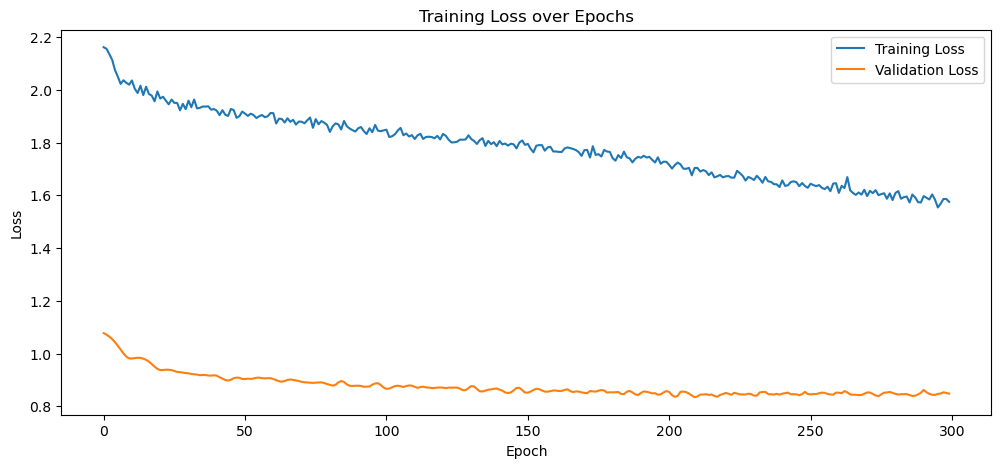

In [62]:
graph = plot_loss(train_losses, val_losses)

#### The above graph shows the training loss and Validation Loss 

#### Saving the model to load angin for the future use

In [63]:
torch.save(model.state_dict(), "21.pth")
print("Model saved to model.pth")

Model saved to model.pth


## (e) (25%) Result analysis: 
<b> Finetune the hyperparameters and use the best trained model predict on the test set (‘[modality]_test.csv’). Organize your predictions according to Kaggle's submission instruction. You MUST beat the benchmark on Kaggle to receive full mark on this portion.

### Sending the test data to gpu for testing on the trained model

In [64]:
structured_data_test = structured_data_test.to(device)
image_test_lh = image_test_lh.to(device)
image_test_bf = image_test_bf.to(device)
cgm_test = cgm_test.to(device)

### Testing the Predecting the labels

In [65]:
model.eval()
with torch.no_grad():
    predictions = model(cgm_test, image_test_bf, image_test_lh, structured_data_test)

In [66]:
predictions.shape

torch.Size([73, 8])

#### Now Converting the tensor predictions to dataframe

In [67]:
predicted = pd.DataFrame(predictions.cpu().numpy())

In [68]:
predicted = (predicted * output_std) + output_mean

In [69]:
predicted.head()

,0,1,2,3,4,5,6,7
0,577.005363,63.647360,18.406357,34.717612,546.318953,52.492197,18.377025,33.226508
1,602.883930,66.170840,17.410476,40.587312,475.878199,33.407670,15.520389,35.968988
2,498.335950,62.957715,15.595149,25.948598,636.172476,78.190373,22.494603,27.967476
3,499.762897,63.024396,15.595470,25.668775,634.120181,78.703290,22.540117,27.927755
4,604.639896,66.526204,17.027338,40.189669,471.920704,33.175642,15.213929,35.577917


#### Now Creating the CSV file with Lunch Calories for the submission

In [84]:
row_id = np.arange(0, len(predictions))

# Create a DataFrame with row_id and flipped predictions
submission_df = pd.DataFrame({
    'row_id': row_id,
    'prediction': predicted.iloc[:, 4]
})

In [85]:
submission_df.to_csv('Lunch_calories_preds.csv', index=False)

In [86]:
print("CSV file created successfully with the following content:")
print(submission_df.head())

CSV file created successfully with the following content:
   row_id  prediction
0       0  546.318953
1       1  475.878199
2       2  636.172476
3       3  634.120181
4       4  471.920704


# Thank You!